In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap==0.36.0

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report

import graphviz
from sklearn.tree import export_graphviz

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import eli5
from eli5.sklearn import PermutationImportance


from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp
import matplotlib.font_manager

import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


**Hotel booking demand**

호텔 사장 Mike가 운영하는 호텔의
매출을 올리기 위한 방법을 찾고 있다.
다양한 방법 중 기존의 문제점을 보완하는 것이 
가장 중요하기에 기존의 문제점을 파악하기 위하여
예약이 취소되었는지 아닌지를 예측하고,
그 사람들이 어떠한 이유로 예약을 취소하였는지 
분석하고, 호텔 운영에 반영하려고 한다.

------
The data is originally from the article **Hotel Booking Demand** Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

https://www.kaggle.com/jessemostipak/hotel-booking-demand

**Data**
- hotel : 호텔의 종류

- is_canceled : 예약의 취소 여부

- lead_time : 예약일과 숙박일 사이의 기간

- arrival_date_year : 호텔 숙박 시작일 중 연

- arrival_date_month : 호텔 숙박 시작일 중 월

- arrival_date_week_number : 호텔 숙박 시작일의 주 번호

- arrival_date_day_of_month : 호텔 숙박 시작일 중 일

- stays_in_weekend_nights : 주말 숙박 일수

- stays_in_week_nights : 평일 숙박 일수

- adults : 투숙객 중 성인의 인원수

- children : 투숙객 중 아동의 인원수

- babies : 투숙객 중 아기의 인원수

- meal : 예약한 식사 유형

- country : 고객의 국적

- market_segment : 마켓 세그먼트

- distribution_channel : 유통 경로

- is_repeated_guest : 재방문 여부

- previous_cancellations : 이전 예약 건 중에 취소된 예약 건의 수

- previous_bookings_not_canceled : 이전 예약 건 중에 취소되지 않은 예약 건의 수

- reserved_room_type : 예약한 객실 유형

- assigned_room_type : 배정된 객실 유형

- booking_changes : 예약일 이후로 예약 내용이 수정된 횟수

- deposit_type : 보증금 유형

- agent : 예약한 여행사

- company : 예약을 하거나 비용을 지불해야하는 회사

- days_in_waiting_list : 예약일과 확인일 사이의 기간

- customer_type : 고객 유형

- adr : 하루 평균 숙박 비용

- required_car_parking_spaces : 요청한 주차공간의 수

- total_of_special_requests : 특별 요청의 수

- reservation_status : 예약 상태

- reservation_status_date : 예약 상태가 정해진 날짜

In [3]:
# 데이터 불러오기
df = pd.read_csv('/content/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.shape

(119390, 32)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
# 결측치 확인
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [7]:
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**결측치가 있는 특성**

- country : 데이터의 개수가 충분히 많기 때문에 결측치를 가진 행을 제거

- agent : 여행사 없이 호텔을 예약한 투숙객들이다. (숫자로 된 column이므로 결측치를 0으로 채운다.)

- company : 결측치가 매우 많으므로 결측치를 채우기보단 column을 제거한다.

- adr : 하루 평균 숙박 비용이 결측치인 것은 숙박 비용이 0이거나 값이 누락된 것으로 추측할 수 있으므로 해당하는 행을 제거해준다.

- children : 결측치를 가진 행이 4개이다. children의 수가 0인지 누락된 값인지 알 수 없으므로 결측치 행을 제거

**분석에 필요하지 않은 특성**

- reservation_status_date : 예약 상태가 정해진 날짜는 예약 취소와 관련이 없을 것이다.

- arrival_date_year

- arrival_date_week_number

- arrival_date_day_of_month : 숙박일의 연도와 일은 취소와 관련이 적을 것이라고 생각한다. 하지만 월(month)는 날씨 등과 관련이 있을 수도 있기 때문에 월만 남겨두고 제거한다.


In [8]:
# 결측치 값 대체
df['agent'] = df['agent'].fillna(0)

# 결측치 많은 company column 제거
df = df.drop('company', axis=1)

# country, children, adr 결측치 행 제거
df = df.dropna(axis = 0)

# 분석에 필요하지 않은 특성 제거
df = df.drop('reservation_status_date', axis=1)
df = df.drop('arrival_date_year', axis=1)
df = df.drop('arrival_date_week_number', axis=1)
df = df.drop('arrival_date_day_of_month', axis=1)
df = df.drop('assigned_room_type', axis=1)

# children float -> int
df['children'] = df['children'].astype('int')

In [9]:
# 전처리 확인
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
dtype: int64

**EDA**

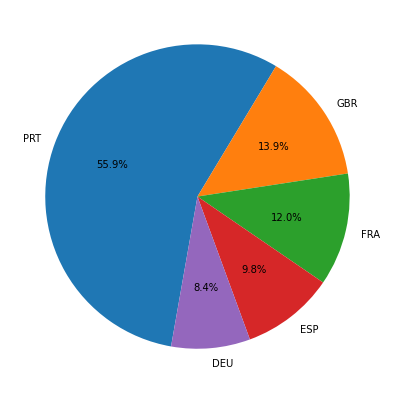

In [10]:
# 국적
# total bookings per market segment
plt.figure(figsize=(14,7))
segments=df["country"].value_counts()
plt.pie(segments[:5], labels=segments[:5].index, autopct='%.1f%%', startangle=260, counterclock=False);

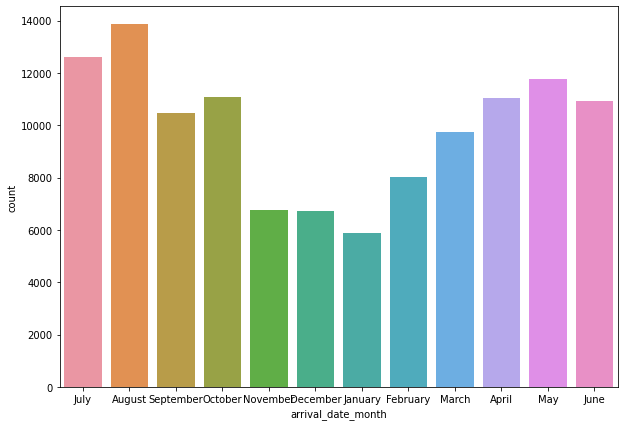

In [11]:
# 월 별 여행자 수
plt.figure(figsize=(10,7))
sns.countplot(x='arrival_date_month', data=df);

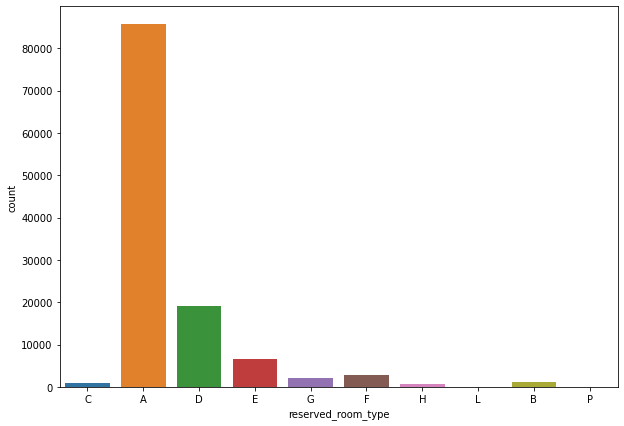

In [12]:
# 가장 예약이 많이 된 객실 유형
plt.figure(figsize=(10,7))
sns.countplot(x='reserved_room_type', data=df);

In [13]:
# 총 숙박 일 수
df['total_stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [14]:
df = df.drop('stays_in_week_nights', axis=1)
df = df.drop('stays_in_weekend_nights', axis=1)

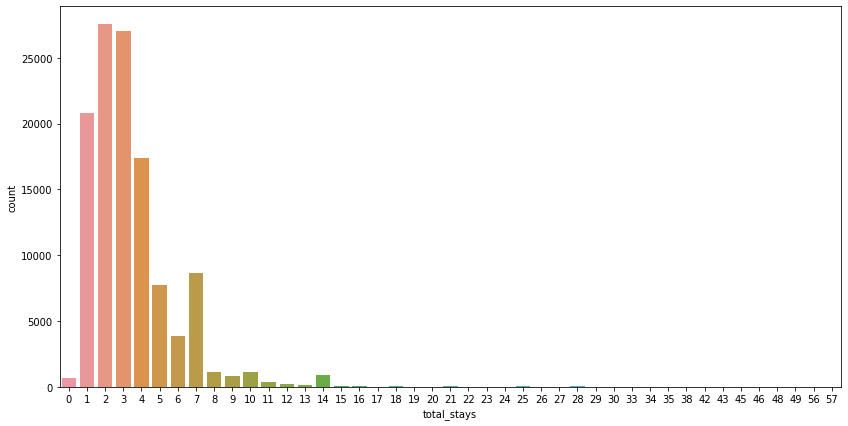

In [15]:
# 숙박 일 수
plt.figure(figsize=(14,7))
sns.countplot(x='total_stays', data=df);

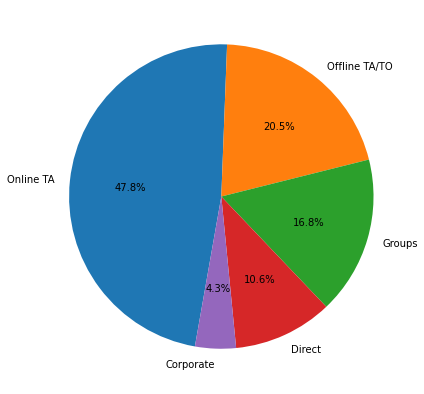

In [16]:
# total bookings per market segment
plt.figure(figsize=(14,7))
segments=df["market_segment"].value_counts()
plt.pie(segments[:5], labels=segments[:5].index, autopct='%.1f%%', startangle=260, counterclock=False);

In [17]:
# 총 인원 수
df['total_people'] = df['adults'] + df['children'] + df['babies']

In [18]:
df['total_people'].unique()

array([ 2,  1,  3,  4,  5, 12, 40, 26, 50, 27, 55,  0, 20,  6, 10])

In [19]:
# total_people이 0인 행 제거
total_zero = df[df['total_people'] == 0].index
df = df.drop(total_zero)

In [20]:
# 확인
df['total_people'].unique()

array([ 2,  1,  3,  4,  5, 12, 40, 26, 50, 27, 55, 20,  6, 10])

In [21]:
df['canceled'] = df[df.is_canceled==1]['total_people']
df['no_canceled'] = df[df.is_canceled==0]['total_people']

In [22]:
plot1 = df.groupby('total_people')['canceled'].count()
plot2 = df.groupby('total_people')['no_canceled'].count()

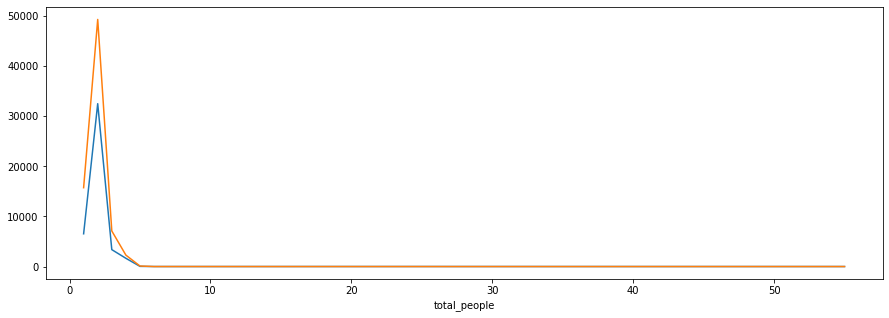

In [23]:
plt.figure(figsize=(15, 5))
plot1.plot()
plot2.plot()

plt.show()

내가 생각한 가설은 '총 인원이 많을수록 시간 맞추기 어려워 예약을 취소할 확률이 증가할 것 같다.' 였는데 가설과 반대의 결과가 나왔다.

여행객이 5명 이하일 때, 예약 취소하는 고객이 많았다. 적은 인원으로 여행을 해서 스케쥴 변동이 쉬워 예약을 쉽게 취소하는 것 같다.

또한, 예약을 취소하지 않는 고객의 총 인원수 그래프와 예약을 취소하는 고객의 총 인원 수 그래프의 모양이 비슷하다. 전반적으로 여행을 하는 인원이 5인 이하에 많기 때문에 이러한 결과가 나온 것 같다.

In [24]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [25]:
# arrival_date_month 값을 int형으로 바꿈
df['month'] = df['arrival_date_month'].replace('January', 1).replace('February', 2)\
                                                   .replace('March', 3).replace('April', 4)\
                                                   .replace('May', 5).replace('June', 6)\
                                                   .replace('July', 7).replace('August', 8)\
                                                   .replace('September', 9).replace('October', 10)\
                                                   .replace('November', 11).replace('December', 12)

In [26]:
df['month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [27]:
df = df.drop('arrival_date_month', axis=1)

In [28]:
# plot을 그릴 때 사용했던 column 제거해준다. -> 정보 누수가 일어나서
df = df.drop('canceled', axis=1)
df = df.drop('no_canceled', axis=1)

**데이터를 훈련/검증/테스트 세트로 나누기**

시계열 데이터가 아니기 때문에 train/validation/test 데이터를 무작위로 나눈다. (60%, 20%, 20%)

In [29]:
train = df.sample(frac = 0.6, random_state = 10)
temp = df.drop(train.index)
val = temp.sample(frac = 0.5, random_state = 10)
test = temp.drop(val.index)

print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

train shape:  (71237, 26)
val shape:  (23746, 26)
test shape:  (23745, 26)


**타겟으로 사용할 특성은 무엇인가?**

예약이 취소되었는지 아닌지 예측할 것이기 때문에 타겟은 **예약의 취소여부(is_canceled)**로 선택한다.

In [30]:
# 타겟 선택
# 0 : 예약이 취소되지 않음. 1 : 예약이 최소됨.
target = 'is_canceled'

**분류 문제인가? 회귀 문제인가?**

고객이 호텔 예약을 취소하였는지 아닌지 예측하는 문제이다.

따라서 예약을 취소하였는지 아닌지 두가지로 분류하는 **이진 분류 문제**이다.

**기준모델 설정 전, 타겟의 분포 분석하기**

클래스가 몇개인지, 클래스 비율이 어떤지 확인합니다.

In [31]:
# 클래스는 2개 이다.
# 0 : 예약이 취소되지 않음. 1 : 예약이 취소됨.
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.629392
1    0.370608
Name: is_canceled, dtype: float64

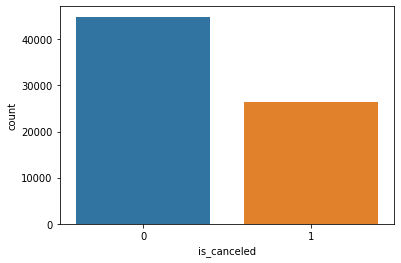

In [32]:
sns.countplot(x=y_train);

**기준모델 설정**

분류문제는 타겟 변수에서 가장 빈번하게 나타나는 범주를 기준모델로 설정합니다. 

In [33]:
# 범주 0 (majority class)으로 모든 예측을 수행
# mode(): Return the highest frequency value in a Series.
major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만든다. (기준모델로 예측)
y_pred = [major] * len(y_train)

In [34]:
# 기준모델로 최다 비율 클래스를 사용할 경우의 정확도
# 최다 클래스의 빈도가 정확도가 된다.
print("기준모델 training accuracy: ", accuracy_score(y_train, y_pred))

기준모델 training accuracy:  0.6293920294229123


In [35]:
# 검증세트의 정확도 확인
y_val = val[target]
y_pred = [major] * len(y_val)
print("기준모델 validation accuracy: ", accuracy_score(y_val, y_pred))

기준모델 validation accuracy:  0.6260422808051882


기준모델로 **최다 비율 클래스를 사용**할 경우

- 훈련 정확도 : 0.629

- 검증 정확도 : 0.626

**사용할 평가지표**

다수 클래스(예약을 취소하지 않음)의 비율이 63%이기 때문에 **정확도(accuracy)**를 사용한다.

f1 score는 정밀도와 재현율의 조화평균입니다 : $ 2\cdot\large\frac{precision\cdot recall}{precision + recall}$

score 값이 높으면 precision과 recall 모두 좋은 결과를 보인다는 것을 알 수 있으므로, 하나의 값으로 2가지 정보를 유추할 수 있다.

따라서, **정확도**와 **f1 score**을 평가지표로 사용한다.

**정보 누수(leakage)가 있는지 확인**

In [36]:
features = df.columns.drop([target, 'is_canceled'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=5, random_state=10)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  1.0


검증 정확도가 1이므로 정보 누수가 있는 것을 확인하였다.

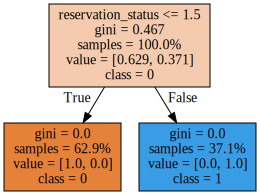

In [37]:
## 어떤 트리가 만들어졌는지 그려봅시다
tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

In [38]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

**reservation_status column에서 정보 누수**가 일어난 것을 확인하였다. reservation_Status는 예약 상태를 나타낸다. 

이 특성은 'Check-Out', 'Canceled', 'No-Show' 값을 가지고 있기 때문에 취소 여부를 예측하는데 있어서 정보가 누수되었다고 할 수 있다.

In [39]:
# 정보 누수가 일어났던 column 제거
X_train = X_train.drop('reservation_status', axis=1)
X_val = X_val.drop('reservation_status', axis=1)
X_test = X_test.drop('reservation_status', axis=1)

**LogisticRegression**

In [40]:
# ordinal encoding 수행
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_train_encoded.head(3)

,hotel,lead_time,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stays,total_people,month
103063,1,157,3,0,0,1,1,1,1,0,0,0,1,2,1,83.0,0,1,92.65,0,0,3,3,12
46288,1,146,2,0,0,1,2,1,1,0,0,0,1,0,1,21.0,99,1,75.00,0,0,3,2,12
39642,2,19,2,0,0,1,3,2,1,0,0,0,1,0,1,240.0,0,2,210.00,0,2,3,2,8


In [41]:
# 특성값들을 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

In [42]:
X_train_scaled

array([[-0.7072259 ,  0.49109479,  1.88313232, ..., -0.17029279,
         1.38508022,  1.763022  ],
       [-0.7072259 ,  0.38863847,  0.22767045, ..., -0.17029279,
         0.03590872,  1.763022  ],
       [ 1.41397537, -0.79426629,  0.22767045, ..., -0.17029279,
         0.03590872,  0.47063992],
       ...,
       [-0.7072259 , -0.05844364,  0.22767045, ...,  0.22332005,
         0.03590872, -0.17555112],
       [-0.7072259 , -0.33786996, -1.42779142, ..., -0.95751848,
        -1.31326279,  1.763022  ],
       [ 1.41397537, -0.51483997, -1.42779142, ...,  0.22332005,
        -1.31326279, -1.14483768]])

In [43]:
# 평균은 0, 표준편차는 1로 표준화
X_train_scaled.T[0].mean(), X_train_scaled.T[0].std()

(-2.6930743666244653e-18, 0.9999999999999999)

In [44]:
model_logistic = LogisticRegression(random_state=10)
model_logistic.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
y_pred = model_logistic.predict(X_val_scaled)
print('logistic model 정확도 : ', accuracy_score(y_val, y_pred))
print('logistic model f1-score : ', f1_score(y_val, y_pred))

logistic model 정확도 :  0.782363345405542
logistic model f1-score :  0.6336310789734865


**DecisionTree**

In [46]:
pipe_decision = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    DecisionTreeClassifier(random_state=10)
)

pipe_decision.fit(X_train, y_train)
y_pred = pipe_decision.predict(X_val)

print('decisiontree model 정확도 : ', accuracy_score(y_val, y_pred))
print('decisiontree model f1-score : ', f1_score(y_val, y_pred))

decisiontree model 정확도 :  0.8467952497262697
decisiontree model f1-score :  0.7950884307761631


**RandomForest**

In [47]:
pipe_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=10)
)

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_val)

print('RandomForest model 정확도 : ', accuracy_score(y_val, y_pred))
print('RandomForest model f1-score : ', f1_score(y_val, y_pred))

RandomForest model 정확도 :  0.886086077655184
RandomForest model f1-score :  0.8419145578867395


**XGBoost**

In [48]:
pipe_XGBoost = make_pipeline(
    OrdinalEncoder(),
#     SimpleImputer(strategy='median'), # xgboost 에서는 missing value 처리를 해 줍니다
    XGBClassifier(random_state=10, n_jobs=-1)
)

pipe_XGBoost.fit(X_train, y_train)

y_pred = pipe_XGBoost.predict(X_val)

print('XGBoost model 정확도 : ', accuracy_score(y_val, y_pred))
print('XGBoost model f1-score : ', f1_score(y_val, y_pred))

XGBoost model 정확도 :  0.8412364187652658
XGBoost model f1-score :  0.7693060824868437


정확도와 f1_score가 높은 두 모델 decisiontree, randomforest모델으로 하이퍼파라미터 튜닝을 하겠습니다.


In [49]:
# decision tree model tuning
# RandomizedSearchCV 를 사용하여 하이퍼파라미터 튜닝 진행
pipe_decision_tuning = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=10)
)

dists = {
    'decisiontreeclassifier__min_samples_leaf': randint(1, 10),
    'decisiontreeclassifier__max_depth': [5, 10, 15, 20, None], 
    'decisiontreeclassifier__max_features': uniform(0, 1), # max_features
    'decisiontreeclassifier__criterion':['gini', 'entropy']
}

clf = RandomizedSearchCV(
    pipe_decision_tuning, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

In [50]:
clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.9s finished


In [51]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('accuracy: ', clf.best_score_)

최적 하이퍼파라미터:  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 15, 'decisiontreeclassifier__max_features': 0.9015073849873034, 'decisiontreeclassifier__min_samples_leaf': 2}
accuracy:  0.8495304654118515


In [52]:
# 가장 성능이 좋은 모델
pipe_decision_tuning = clf.best_estimator_

In [53]:
y_pred = pipe_decision_tuning.predict(X_val)

print('decisiontree model 정확도 : ', accuracy_score(y_val, y_pred))
print('decisiontree model f1-score : ', f1_score(y_val, y_pred))

decisiontree model 정확도 :  0.8548808220331845
decisiontree model f1-score :  0.800694042799306


In [54]:
# randomforest model tuning
pipe_rf_tuning = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

dists = {
    'randomforestclassifier__n_estimators': randint(0, 300),
    'randomforestclassifier__min_samples_split': randint(1, 10),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__criterion':['gini', 'entropy']
}

clf = RandomizedSearchCV(
    pipe_rf_tuning, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

In [55]:
clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.2min finished


In [56]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('accuracy: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__n_estimators': 193}
accuracy:  0.8770722996049692


In [57]:
pipe_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, criterion='gini', max_depth=None, 
                           min_samples_split=4, n_estimators=245)
)

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_val)

print('RandomForest model 정확도 : ', accuracy_score(y_val, y_pred))
print('RandomForest model f1-score : ', f1_score(y_val, y_pred))

RandomForest model 정확도 :  0.8859176282321233
RandomForest model f1-score :  0.8415696824375696


**최종 모델**

랜덤포레스트 모델을 하이퍼파라미터 튜닝한 모델을 최종 모델로 결정


In [58]:
pipe_final = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, criterion='gini', max_depth=None, 
                           min_samples_split=4, n_estimators=245)
)

pipe_final.fit(X_train, y_train)
y_pred = pipe_final.predict(X_val)

print('최종 model 정확도 : ', accuracy_score(y_val, y_pred))
print('최종 model f1-score : ', f1_score(y_val, y_pred))

최종 model 정확도 :  0.8859176282321233
최종 model f1-score :  0.8415696824375696


In [59]:
# precision, recall 확인
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     14866
           1       0.88      0.81      0.84      8880

    accuracy                           0.89     23746
   macro avg       0.88      0.87      0.88     23746
weighted avg       0.89      0.89      0.88     23746



In [60]:
# test data
# 예측
y_pred_test = pipe_final.predict(X_test)

# 결과 확인
print("최종 model test 정확도: ", accuracy_score(y_test, y_pred_test))
print("최종 model test f1_score: ", f1_score(y_test, y_pred_test))

최종 model test 정확도:  0.8838071172878501
최종 model test f1_score:  0.837639027834991


검증 데이터 셋 정확도와 f1_score와 테스트 셋 정확도, f1_score가 비슷한 값이 나왔다.

**permutation importance**

In [61]:
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy='mean'))),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, criterion='gini', max_depth=None, 
                           min_samples_split=4, n_estimators=245)) 
])

In [62]:
# pipeline 생성을 확인
pipe.named_steps

{'preprocessing': Pipeline(memory=None,
          steps=[('ordinalencoder',
                  OrdinalEncoder(cols=None, drop_invariant=False,
                                 handle_missing='value', handle_unknown='value',
                                 mapping=None, return_df=True, verbose=0)),
                 ('simpleimputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='mean',
                                verbose=0))],
          verbose=False),
 'rf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=4,
                        min_weight_fraction_leaf=0.0, n_estimators=245,
         

In [63]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))
print("f1_score: ", f1_score(y_val, y_pred))

검증 정확도:  0.8859176282321233
f1_score:  0.8415696824375696


In [64]:
# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=10
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [65]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

babies                            0.000025
children                          0.000025
days_in_waiting_list              0.000118
total_people                      0.000261
is_repeated_guest                 0.000404
adults                            0.000463
previous_bookings_not_canceled    0.001356
reserved_room_type                0.001887
meal                              0.005121
distribution_channel              0.007496
hotel                             0.007850
total_stays                       0.009905
booking_changes                   0.010806
month                             0.011076
required_car_parking_spaces       0.013636
adr                               0.023549
market_segment                    0.024383
customer_type                     0.026185
previous_cancellations            0.027828
deposit_type                      0.039021
agent                             0.056169
lead_time                         0.057424
total_of_special_requests         0.064154
country    

In [66]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0803 ± 0.0035,country
0.0642 ± 0.0022,total_of_special_requests
0.0574 ± 0.0029,lead_time
0.0562 ± 0.0033,agent
0.0390 ± 0.0015,deposit_type
0.0278 ± 0.0012,previous_cancellations
0.0262 ± 0.0021,customer_type
0.0244 ± 0.0028,market_segment
0.0235 ± 0.0023,adr
0.0136 ± 0.0008,required_car_parking_spaces


순열중요도 결과를 보면 country, total_of_special_requests, lead_time 순서로 타켓에 영향을 주는 것으로 나타났다.

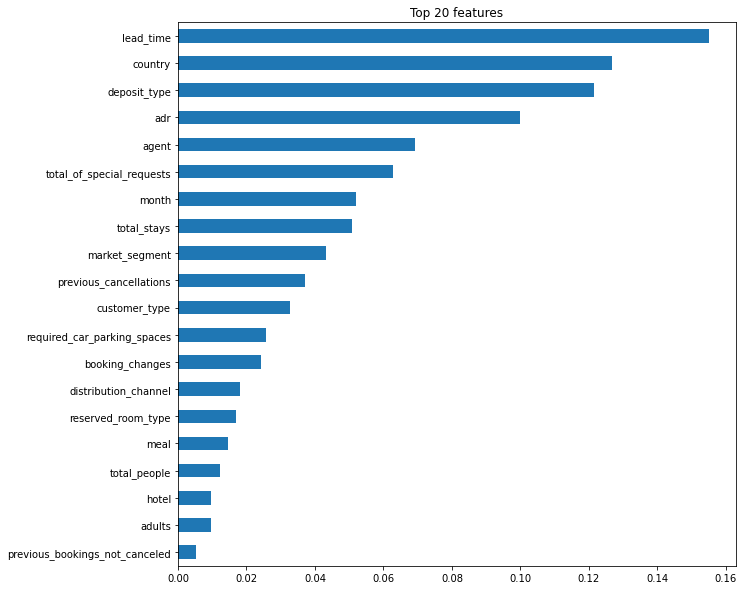

In [67]:
# 특성 중요도
rf = pipe.named_steps['rf']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

특성 중요도 결과는 lead_time, country, deposit_type 순으로 타켓에 영향을 주는 것으로 나타났다.

순열 중요도의 결과와 다르다.

**PDP**

부분의존도그림(Partial dependence plots, PDP)을 사용하면 관심있는 특성들이 타겟에 어떻게 영향을 주는지 쉽게 파악할 수 있습니다.

In [68]:
plt.rcParams['figure.dpi'] = 80

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


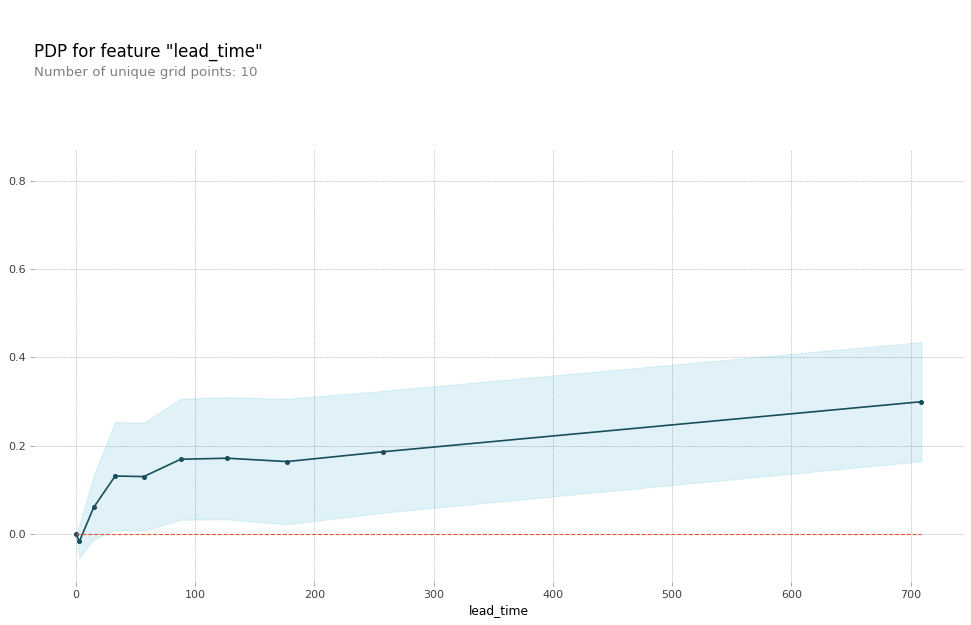

In [69]:
# lead_time에 대한 PDP
feature1 = 'lead_time'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns,
    feature=feature1,
)
pdp_plot(isolated, feature_name=feature1);

'lead_time'에 대한 pdp 결과를 보면 숙박 일자와 예약 일자와의 간격이 클수록 예약을 취소할 확률이 커지는 것을 확인할 수 있다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


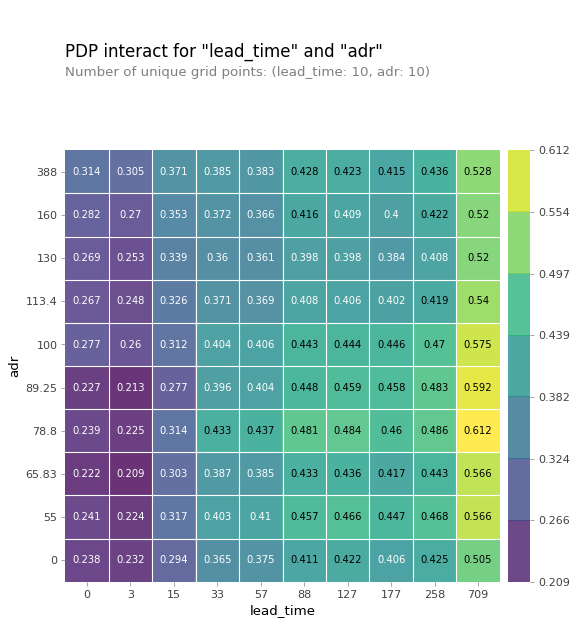

In [71]:
# lead_time 과 adr 의 관계에 대한 PDP
features2 = ['lead_time', 'adr']

interaction = pdp_interact(
    model=pipe, 
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns, 
    features=features2
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features2);

그래프를 보면 오른쪽으로 갈수록 예약을 취소할 확률이 높아지는 것을 알 수 있다.

숙박일자와 예약일자 사이의 간격이 클 때, 예약을 취소할 확률이 커진다.

숙박요금이 78.8이고, lead_time이 709일일 때의 값이 0.612로 취소할 확률이 제일 높다.

**SHAP 라이브러리**

In [72]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

model = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, criterion='gini', max_depth=None, 
                           min_samples_split=4, n_estimators=245)

model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_val_encoded)

print('정확도', model.score(X_val_encoded, y_val))
print("f1_score: ", f1_score(y_val, model.predict(X_val_encoded)))

정확도 0.8859176282321233
f1_score:  0.8415696824375696


In [84]:
explainer = shap.TreeExplainer(model)

In [85]:
# 4번째 샘플의 shap value
row = X_test_encoded.iloc[[3]]
row

,hotel,lead_time,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stays,total_people,month
15,2,68,2,0,0,1,12.0,2,1,0,0,0,2,0,1,240.0,0,2,97.0,0,3,4,2,7


In [86]:
# 예약 취소 여부
y_test.iloc[[3]]

15    0
Name: is_canceled, dtype: int64

In [87]:
# 모델 예측값
model.predict(row)

array([0], dtype=int64)

In [88]:
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], row)

기준 값은 0.3705이고, 그보다 작은 0.17이라는 값을 가지기 때문에 예측값이 0으로 나왔습니다. 예측치에 가장 크게 영향을 끼친 특성은 특별한 요청을 한 개수와 국적 인것을 알 수 있습니다.

In [107]:
# 2001번째 샘플의 shap value
row = X_test_encoded.iloc[[2000]]
row

,hotel,lead_time,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stays,total_people,month
10186,2,74,2,0,0,1,1.0,5,3,0,0,0,1,0,1,0.0,0,1,40.0,0,0,2,2,2


In [106]:
# 예약 취소 여부
y_test.iloc[[2000]]

10186    1
Name: is_canceled, dtype: int64

In [108]:
# 모델 예측값
model.predict(row)

array([1], dtype=int64)

In [109]:
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], row)

기준 값은 0.3705이고, 그보다 큰 1.00이라는 값을 가지기 때문에 예측값이 1으로 나왔습니다. 예측치에 가장 크게 영향을 끼친 특성은 국적과 숙박일과 예약일 간의 차이인것을 알 수 있습니다.